Security Metrics Maturity

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.optimize import fsolve
import seaborn as sns

In [2]:
from utils import plot_nominal, plot_bayes_beta

## decision-first, predictive analytics

In [3]:
xlabels = ['beliefs & \nad-hoc data', 
           'security vendor\n data', 
           'integrated data\n sources',
           'unstructured real-\ntime big data']
ylabels = ['what should I \n invest?', 
           'Is individual \ninvestment working?', 
           'Are investments\n working together?',
           'Am I finding &\n stopping hidden threats?']
annots = [((0.7, 0.8), 'sparse data\n analytics'),
          ((1.7, 1.8), 'functional\n security metrics'),
          ((2.7, 2.8), 'security\n data marts'),
          ((3.7, 3.8), 'prescriptive\n analytics')]

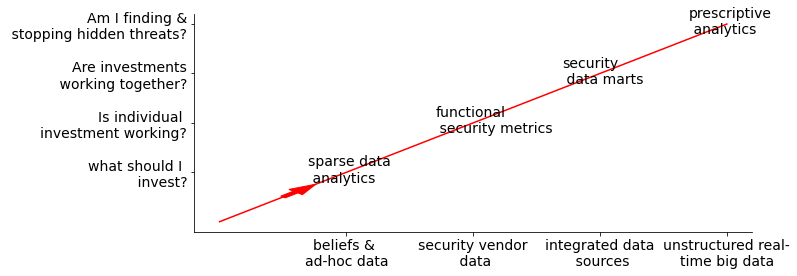

In [4]:
plot_nominal(xlabels, ylabels, tick_size=14, fig_size=(10, 4),
             annots=annots)

## sparse data analytics

### prior

We model our belief of the proportion of the controls that are in place with the beta-distribution. Suppose we feel 50% confident that the true proportion is less than 40%, and 90% sure it's less than 60%, then we have two equations 
\begin{align}
B(0.4, a, b) & = 0.5,\\
B(0.6, a, b) & = 0.9,
\end{align}
where $$B(x, a, b)=\int_0^x p_\beta(x, a, b) dx$$ is the cumulative distribution function for beta-distribution.

We now solve for the shape paramters, $a$ and $b$, from the above two equations.

#### solve

In [5]:
def func(x):
    return [stats.beta.cdf(0.4, x[0], x[1]) - 0.5,
            stats.beta.cdf(0.6, x[0], x[1]) - 0.9]

root = fsolve(func, [1, 1])
(a_prior, b_prior) = root

In [6]:
a_prior, b_prior

(4.309745030665892, 6.302591788331008)

#### visualize

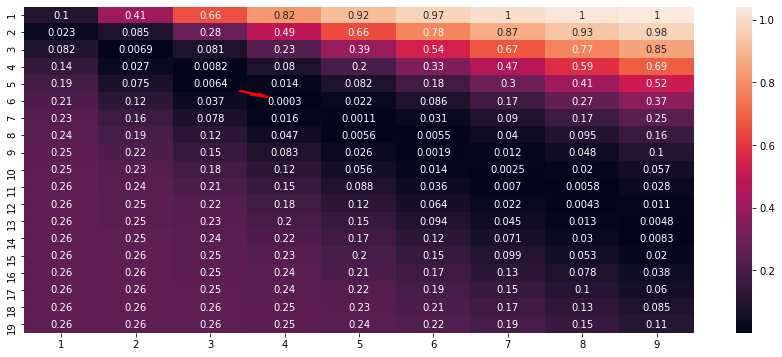

In [7]:
a_list = range(1, 10)
b_list = range(1, 20)
A, B = np.meshgrid(a_list, b_list)

# Grid-search for the (a,b) that minimizes the loss function.
loss = (stats.beta.cdf(0.4, A, B) - 0.5)**2 + (stats.beta.cdf(0.6, A, B) - 0.9)**2

val = np.min(loss)
pos = np.unravel_index(np.argmin(loss), loss.shape)  

fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(loss, annot=True, ax=ax, 
           xticklabels=a_list, yticklabels=b_list)
ax.arrow(pos[1]-0.1, pos[0]-0.1, 0.2, 0.2, width=0.06, color='r')

### observation: 3 out of 10

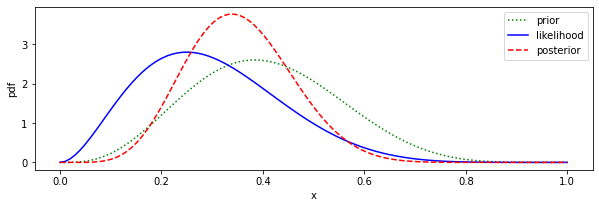

In [8]:
plot_bayes_beta((a_prior, b_prior), (3, 7), fig_size=(10, 3))

### observation: 5 out of 35

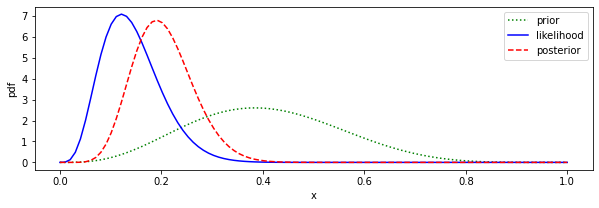

In [9]:
plot_bayes_beta((a_prior, b_prior), (5, 30), fig_size=(10, 3))

Now let's get the 90% Confidence Interval:

In [10]:
a_posterior, b_posterior = a_prior+5, b_prior+30

In [11]:
# beta.isf is the inverse of sf (survival function, beta.sf = 1-beta.cdf)
# x_left, x_right = stats.beta.isf(0.95, a_posterior, b_posterior), stats.beta.isf(0.05, a_posterior, b_posterior)
x_left, x_right = stats.beta.interval(0.9, a_posterior, b_posterior)

In [12]:
x_left, x_right

(0.11485098496507312, 0.3082418859427346)

### The redundant Monte Carlo simulations

Here the authors continues to do a Monte Carlo simulation to get the confidence interval, which apparently adds no new information. With enough trials, we would recover the same $x_\text{left}$ and $x_\text{right}$ as above, below we will show just that.

In [13]:
x_list_1k = stats.beta.rvs(a_posterior, b_posterior, size=1000)
x_list_1m = stats.beta.rvs(a_posterior, b_posterior, size=1000000)

In [14]:
np.quantile(x_list_1k, [0.05, 0.95])

array([0.11043108, 0.30025805])

In [15]:
np.quantile(x_list_1m, [0.05, 0.95])

array([0.11491089, 0.30791851])

### The useful Monte Carlo simulations

The Monte Carlo simulations can be used to generate samples. Here we need to generate binary-valued samples, the number of 1 satisfying a binomial distribution of paramter $p$, which is in turn described by a beta distribution (that sounds complicated, but that's what beta distribution is used for.

I believe the numbers on page 211 (91% confident the successful outcomes to be between 17 and 56) are wrong. 

In [16]:
def generate_binary_from_beta(a, b, size=200, trial=1000):
    p_list = stats.beta.rvs(a, b, size=size*trial)
    rand_list = np.random.rand(size*trial)
    success = rand_list < p_list
    return success.reshape(trial, size)

In [17]:
successes = np.sum(generate_binary_from_beta(a_posterior, b_posterior, 200, 1000), axis=1)

In [18]:
successes.shape

(1000,)

(array([  4.,  20.,  78., 142., 240., 214., 184.,  75.,  33.,  10.]),
 array([23. , 26.5, 30. , 33.5, 37. , 40.5, 44. , 47.5, 51. , 54.5, 58. ]),
 <BarContainer object of 10 artists>)

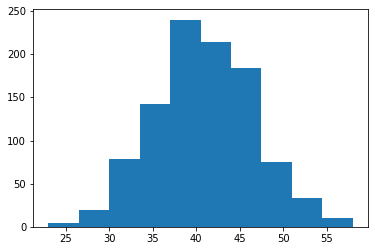

In [19]:
plt.hist(successes)

In [20]:
np.quantile(successes, [0.045, 0.955])

array([31., 50.])

## functional security metrics

Following the performance of your security investments:
1. Converage & configuration metrics, e.g., if configuration is correct, false positive rate, etc..
2. Mitigation metrics, e.g., REV recovery time within 1 day, and monitoring established within 1 hour.

c.f. "security metrics" by Andrew Jaquith

## security data marts

Use historical data to estimate residual (undetected, or zero-day vulnerabilities) after ALL investments in security are done. SIEM cannot do that because the data needed to calculate the residual risk can be year's long.

## Prescriptive analytics = modelling + decision